# fvGP Single-Task Test

In [1]:
#!pip install fvgp~=4.7.3

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from fvgp import GP
import time
from distributed import Client
client = Client()

%load_ext autoreload
%autoreload 2

In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data

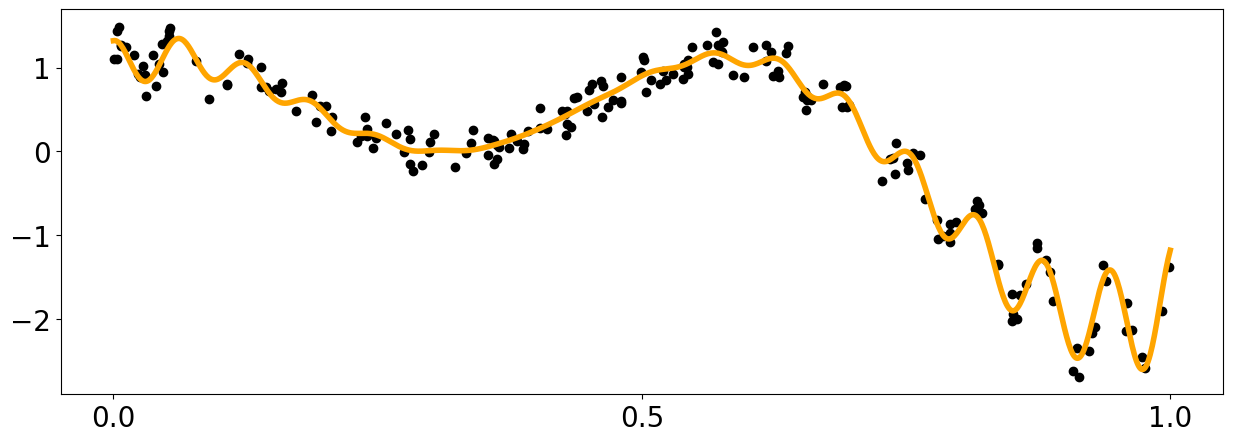

In [4]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
#np.random.seed(42)
x_data = np.random.rand(200).reshape(-1,1) 
y_data = f1(x_data[:,0]) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

## Customizing a Gaussian Process

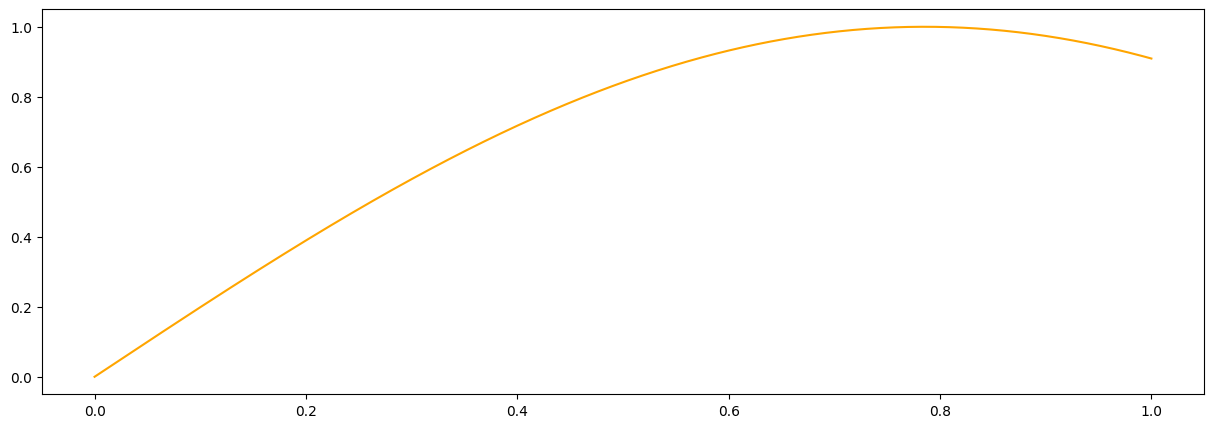

In [5]:
from fvgp.kernels import *
from scipy import sparse
def my_noise(x,hps):
    #This is a simple noise function, but can be arbitrarily complex using many hyperparameters.
    #The noise can be a vector, a matrix, or a sparse matrix in case gp2Scale is used.  
    return np.zeros(len(x)) + hps[2]

#stationary
def skernel(x1,x2,hps):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])


def meanf(x, hps):
    #This ios a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

## Initialization and different training options

In [6]:
st = time.time()
from loguru import logger
logger.disable("fvgp")
my_gp1 = GP(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # we need enough of those for kernel, noise, and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.1, # providing noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            kernel_function=skernel, 
            kernel_function_grad=None, 
            #prior_mean_function=meanf, 
            prior_mean_function_grad=None,
            #noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False,
            )


hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,0.1],  #noise
                       [0.01,1.]  #mean
                      ])
#my_gp1.update_gp_data(x_data, y_data, noise_variances_new=np.ones(y_data.shape) * 0.05) #this is just for testing, not needed
print("Standard Training (MCMC)")
my_gp1.train(hyperparameter_bounds=hps_bounds, info = True, max_iter = 100)
print(time.time() - st)
print("Global Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='global', max_iter = 20)
print("hps: ", my_gp1.hyperparameters)
print("Local Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='local')
print(my_gp1.hyperparameters)
print("HGDL Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=2, dask_client=client)
print(my_gp1.hyperparameters)

Standard Training (MCMC)
Finished  10  out of  100  MCMC iterations. f(x)=  -61.92720631302355
Finished  20  out of  100  MCMC iterations. f(x)=  -61.92720631302355
Finished  30  out of  100  MCMC iterations. f(x)=  -39.909433146330116
Finished  40  out of  100  MCMC iterations. f(x)=  -38.64534031215467
Finished  50  out of  100  MCMC iterations. f(x)=  -35.2172153929109
Finished  60  out of  100  MCMC iterations. f(x)=  -34.723921393323906
Finished  70  out of  100  MCMC iterations. f(x)=  -35.05203115440278
Finished  80  out of  100  MCMC iterations. f(x)=  -35.382291509608194
Finished  90  out of  100  MCMC iterations. f(x)=  -34.37999264298148
0.06238150596618652
Global Training
hps:  [2.07744358 0.41495824 0.0851668  0.36043073]
Local Training
[2.07745621 0.41474208 0.0851668  0.36043073]
HGDL Training
[2.07449228 0.41450607 0.0030665  0.65383064]


In [7]:
my_gp1.x_data.shape

(200, 1)

### More advanced: Asynchronous training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different training runs on different computers.
This training will continue without any signs of life until you query  the solution via 'update_hyperparameters(object)' or call 'my_gp1.stop_training(opt_obj)'

In [19]:
my_gp1.set_hyperparameters(np.array([1,1,1,1]))

In [20]:
print(my_gp1.hyperparameters)
opt_obj = my_gp1.train_async(hyperparameter_bounds=hps_bounds, dask_client=client)

[1 1 1 1]


In [21]:
# The result won't change much (or at all) since this is such a simple optimization
for i in range(20):
    time.sleep(0.1)
    print("iteration ", i)
    my_gp1.update_hyperparameters(opt_obj)
    print(my_gp1.hyperparameters)

iteration  0
[1 1 1 1]
iteration  1
[1 1 1 1]
iteration  2
[1 1 1 1]
iteration  3
[1 1 1 1]
iteration  4
[1 1 1 1]
iteration  5
[2.07449704 0.41450642 0.01649214 0.77501653]
iteration  6
[2.07449704 0.41450642 0.01649214 0.77501653]
iteration  7
[2.07449704 0.41450642 0.01649214 0.77501653]
iteration  8
[2.07449704 0.41450642 0.01649214 0.77501653]
iteration  9
[2.07449704 0.41450642 0.01649214 0.77501653]
iteration  10
[2.07449704 0.41450642 0.01649214 0.77501653]
iteration  11
[2.07449704 0.41450642 0.01649214 0.77501653]
iteration  12
[2.07449704 0.41450642 0.01649214 0.77501653]
iteration  13
[2.07449704 0.41450642 0.01649214 0.77501653]
iteration  14
[2.07449704 0.41450642 0.01649214 0.77501653]
iteration  15
[2.07449704 0.41450642 0.01649214 0.77501653]
iteration  16
[2.07449704 0.41450642 0.01649214 0.77501653]
iteration  17
[2.07449704 0.41450642 0.01649214 0.77501653]
iteration  18
[2.07449704 0.41450642 0.01649214 0.77501653]
iteration  19
[2.07449704 0.41450642 0.01649214 0.

In [22]:
my_gp1.stop_training(opt_obj) ##this leaves the dask client alive, kill_client() will shut it down. 

## The Result

In [13]:
my_gp1.hyperparameters
#DOES NOT WORK: array([0.80096475, 0.0662706 , 0.08988444, 0.25189999])
#DOES     WORK: array([0.84519429, 0.06890454, 0.09399283, 0.23367273])
my_gp1.set_hyperparameters(np.array([0.99060988, 0.07606013, 0.0993521 , 0.01268085]))

In [14]:
#print(my_gp1.m)
#print(my_gp1.V)

Posterior Mean and Uncertainty


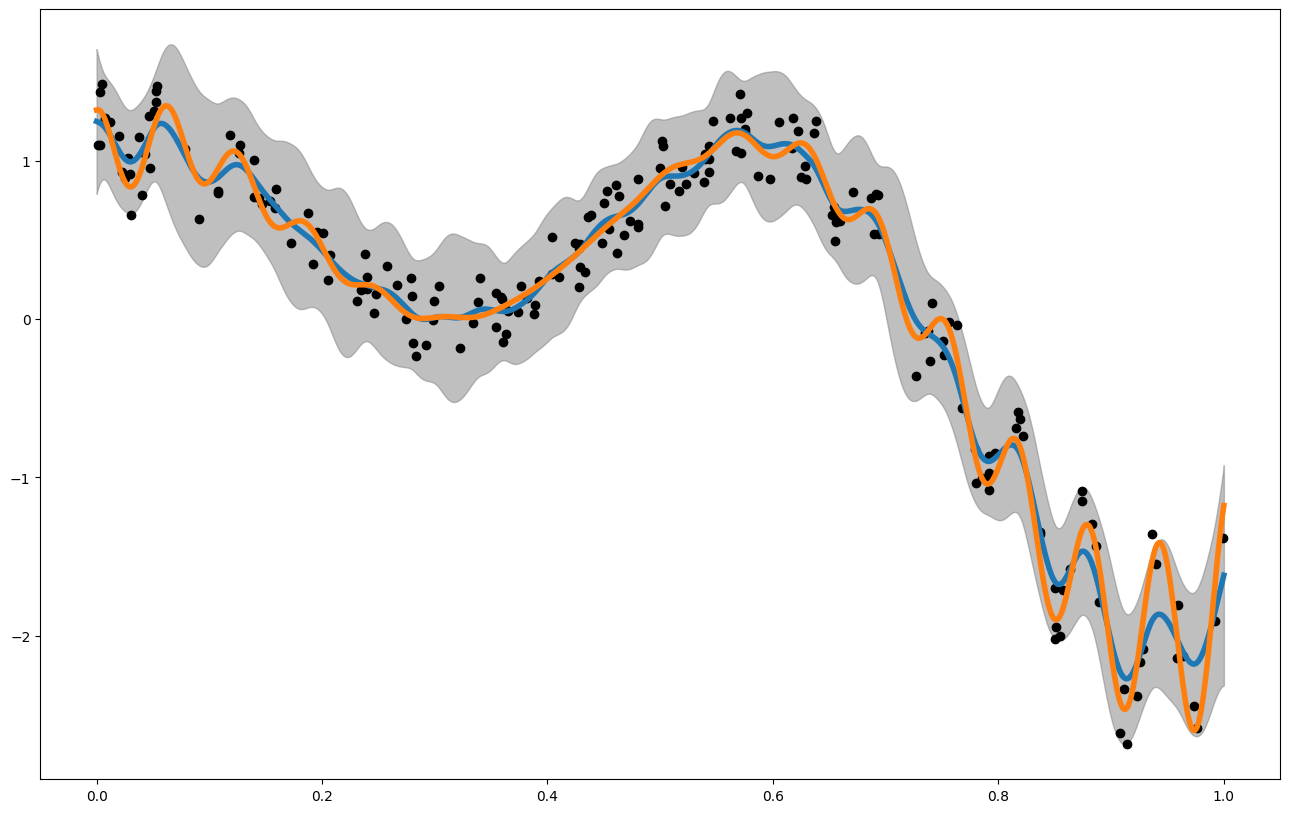

Posterior Mean Gradient


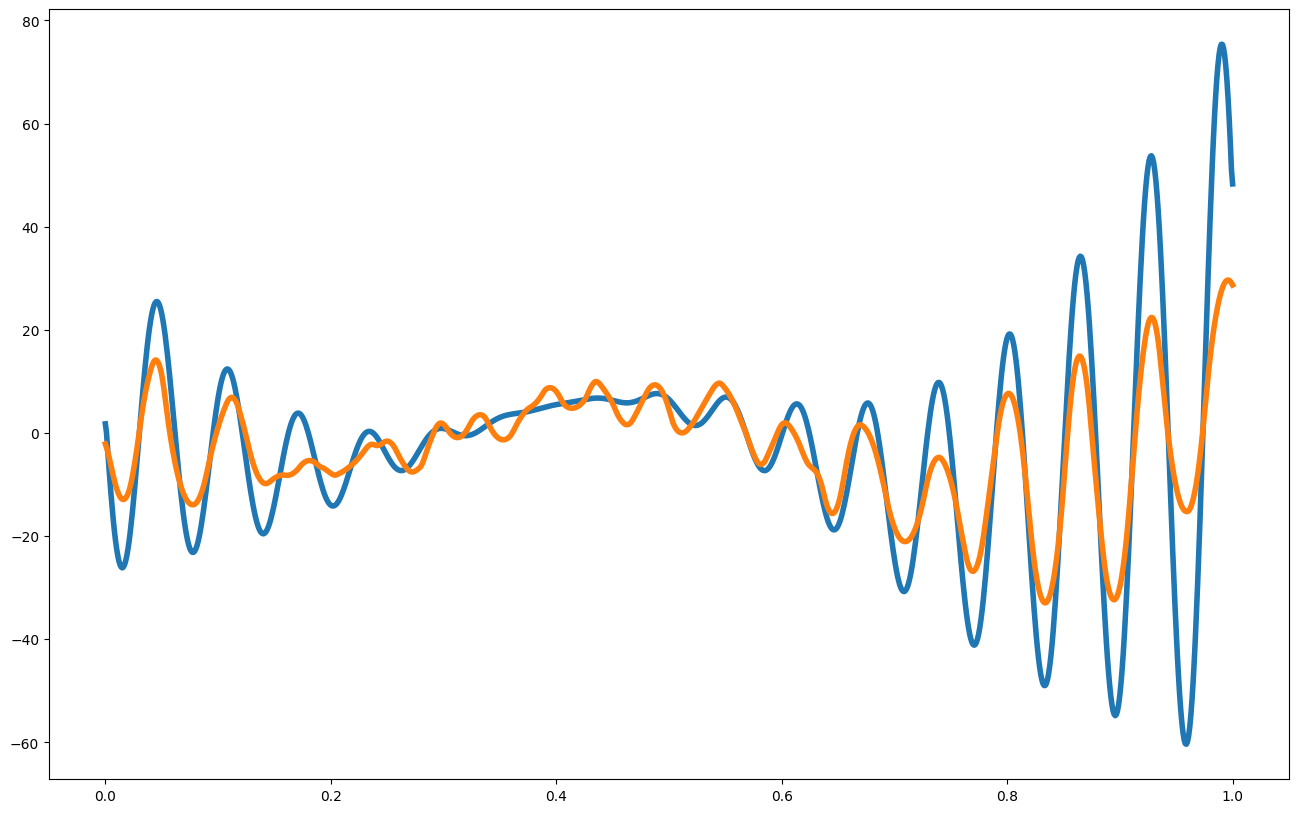

RMSE:              0.11302159783733748
CRPS (mean, std):  (np.float64(0.060269185092408493), np.float64(0.05765550970851749))
R2:                0.9880018897051321
NLPD:              -0.7640292172409413


In [15]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)


# different ways to call 
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=False)["v(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["m(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
mean_grad = my_gp1.posterior_mean_grad(x_pred.reshape(-1,1), direction=0)["dm/dx"]

print("Posterior Mean and Uncertainty")
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(my_gp1.x_data,my_gp1.y_data, color = 'black')
plt.show()

print("Posterior Mean Gradient")
plt.figure(figsize = (16,10))
dx = 1./len(x_pred)
plt.plot(x_pred1D,np.gradient(f1(x_pred1D).flatten(), dx), label = "ground truth gradient", linewidth = 4)
plt.plot(x_pred1D,mean_grad, label = "posterior mean grad", linewidth = 4)
plt.show()



##looking at some validation metrics
print("RMSE:             ",my_gp1.rmse(x_pred1D,f1(x_pred1D).flatten()))
print("CRPS (mean, std): ",my_gp1.crps(x_pred1D,f1(x_pred1D).flatten()))
print("R2:               ",my_gp1.r2(x_pred1D,f1(x_pred1D).flatten()))
print("NLPD:             ",my_gp1.nlpd(x_pred1D,f1(x_pred1D).flatten()))

## Predicted Information Gain

In [16]:
relative_entropy =  my_gp1.gp_relative_information_entropy_set(x_pred.reshape(-1,1))["RIE"]

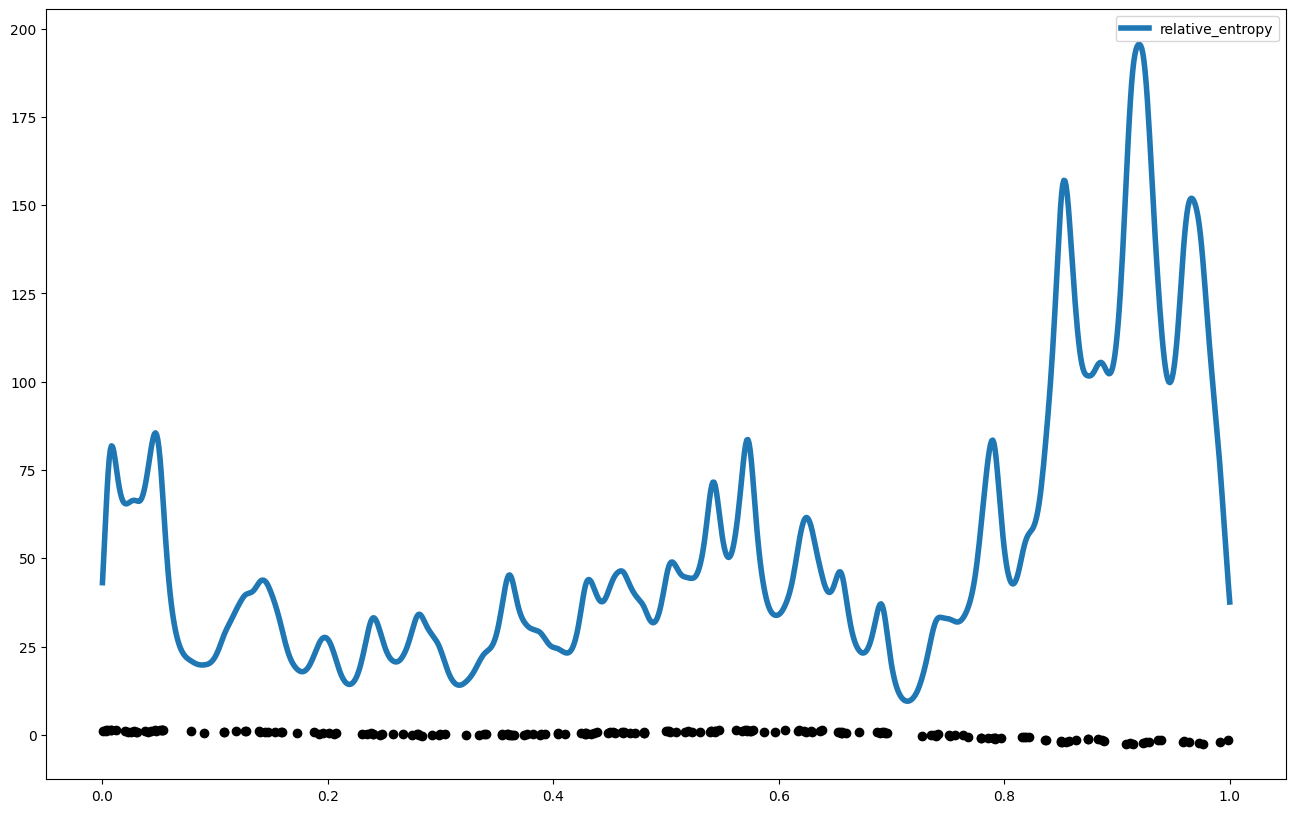

In [17]:
plt.figure(figsize = (16,10))
plt.plot(x_pred,relative_entropy, label = "relative_entropy", linewidth = 4)
plt.scatter(x_data,y_data, color = 'black')
plt.legend()

In [18]:
#We can ask mutual information and total correlation there is given some test data
x_test = np.array([[0.45],[0.45]])
print("MI: ",my_gp1.gp_mutual_information(x_test))
print("TC: ",my_gp1.gp_total_correlation(x_test))
my_gp1.gp_entropy(x_test)
my_gp1.gp_entropy_grad(x_test, 0)
my_gp1.gp_kl_div(x_test, np.ones((len(x_test))), np.identity((len(x_test))))
my_gp1.gp_relative_information_entropy(x_test)
my_gp1.gp_relative_information_entropy_set(x_test)
my_gp1.posterior_covariance(x_test)
my_gp1.posterior_covariance_grad(x_test)
my_gp1.posterior_mean(x_test)
my_gp1.posterior_mean_grad(x_test)
my_gp1.posterior_probability(x_test, np.ones((len(x_test))), np.identity((len(x_test))))

MI:  {'x': array([[0.45],
       [0.45]]), 'mutual information': np.float64(6.768642913112899)}
TC:  {'x': array([[0.45],
       [0.45]]), 'total correlation': np.float64(16.778984905109326)}


{'mu': array([0.62176205, 0.62176205]),
 'covariance': array([[0.01284231, 0.01284221],
        [0.01284221, 0.01284231]]),
 'probability': np.float64(0.13564385808873183)}